# Alternative Fuel Station Location Optimization in the Twin Cities Metropolitan Area

### Luke Zaruba<br>GIS 5571: ArcGIS I (Spatial Data Science I)<br>December 14, 2022

**Abstract**
<br>
*With renewable energy and sustainable transportation becoming key focuses for urban planning and development in the coming decades, infrastructure for supplying sustainable alternative fuels for transportation will become a key issue, especially given the United States’ reliance upon gas and oil, along with the country’s aging energy system. In order to efficiently and effectively provide adequate alternative fueling infrastructure to the nation, GIS and spatial data science techniques can be used to optimize coverage and minimize costs. This project aims to use two prominent methods developed in the field of operations research, for optimizing the rollout of alternative fueling stations in the Twin Cities Metropolitan Area (TCMA) by maximizing coverage and minimizing resources. The project will show how the techniques can be used at a local or regional level, but the analysis is scalable, and can be used at much smaller scales (larger extents), like across the U.S. Interstate System.*

In [1]:
# Import Packages
import numpy as np
import geopandas as gpd
import pandas as pd
import requests
import contextily
import matplotlib.pyplot as plt

%matplotlib inline

## Retrieving Potential Facility Locations

The first step of any analysis is to extract, transform, and load the data needed. This is often referred to as ETL, or data wrangling/cleaning. First, we need to identify potential locations that we can place alternative fuel stations at. The easiest locations are typically gas stations, since they are located in ideal spots and have existing infrastructure and resources that will make it easier to add in alternative fueling infrastructure.

To get a dataset of gas stations, we will use the Google Places API to iteratively extract gas stations over subsets of the study area, before combining the results and cleaning it up.

In [2]:
# Function that makes call to the Google Places API and returns the result as a JSON
def searchGoogle(lat, long, radius, keyword, api_key):
    # Replacing URL substrings with search parameters
    google_places = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location=LOC&radius=RAD&type=TYPE&keyword=KW&key=YOUR_API_KEY"

    location = str(lat) + "%2C" + str(long)

    google_places = google_places.replace("LOC", location)
    google_places = google_places.replace("RAD", str(radius))
    google_places = google_places.replace("KW", keyword)
    google_places = google_places.replace("YOUR_API_KEY", api_key)

    # Getting request
    payload = {}
    headers = {}

    response = requests.request("GET", google_places, headers=headers, data=payload)

    # Note: Not an actual JSON - can keep to use Python list/dist methods for parsing
    json_response = response.json()

    return json_response["results"]


# Function that converts the JSON from the searchGoogle() function to a GeoPandas GeoDataFrame
def googleJsonToDf(json_input):
    # Create DF with column names
    df = pd.DataFrame(columns=("Name", "Latitude", "Longitude", "Address", "Icon_URL"))
    
    # Loop through the JSON and add all features to the DF
    for i in range(len(json_input)):
        name = [json_input[i]["name"]]
        lat = [json_input[i]["geometry"]["location"]["lat"]]
        lng = [json_input[i]["geometry"]["location"]["lng"]]
        address = [json_input[i]["vicinity"]]
        icon = [json_input[i]["icon"]]
        
        df.loc[i] = name + lat + lng + address + icon
    
    # Convert DF to GDF, set CRS, and return
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    
    gdf.set_crs("EPSG:4326")
        
    return gdf


# Function that iterates over an area and adds each search result to a master DF
def iterateSearch():
    final_df = pd.DataFrame(columns=("Name", "Latitude", "Longitude", "Address", "Icon_URL"))
    
    for i in np.arange(-94.012, -92.732, 0.05):
        for j in np.arange(44.471, 45.415, 0.05):
            i_query = searchGoogle(j, i, "10000", "gas station", key)
            i_res = googleJsonToDf(i_query)
            final_df = pd.concat([i_res, final_df], axis = 0)
            
    return final_df

## Why do we need to iteratively perform searchs/API calls?

Altough the Google Places API does have a distance parameter that can return results within a given distance of a location, through some testing, there were inconsistencies found that resulted in the decision to iteratively perform many searchs, just for peace of mind. Even with this additional functionality that was created, the searches are still not perfect (related to data quality, rather than API call parameters) and there are likely some missing features, but the resulting dataset is sufficient enough to get a better understanding of where existing infrasturcture is.

In [3]:
# API KEY - In future, try to implement using YAML
key = "YOUR_API_KEY_HERE"

In [4]:
# Run the Function
results = iterateSearch()

# Get the Output DF's Size
print(f"The intitial number of features returned is {len(results)} features.")

The intitial number of features returned is 9873 features.


In [5]:
# Clean up DF and remove duplicates
results_cleaned = results.drop_duplicates(keep = "first")

# Get Cleaned DF's Size
print(f"The number of non-duplicate features returned is {len(results_cleaned)} features.")

677

In [6]:
# Reset the Index
results_cleaned = results_cleaned.reset_index(drop=True)

results_cleaned

,Name,Latitude,Longitude,Address,Icon_URL,geometry
0,Kwiktrip Gas Station,45.509058,-92.998324,"5435 St Croix Trail, North Branch",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-92.99832 45.50906)
1,bp,45.261315,-92.967319,"1107 Scandia Trail N, Forest Lake",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-92.96732 45.26132)
2,Shell,45.274403,-92.983999,"408 Lake St S, Forest Lake",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-92.98400 45.27440)
3,Holiday Stationstores,45.390146,-92.844513,"12970 Lake Blvd, Lindstrom",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-92.84451 45.39015)
4,bp,45.24514,-92.697847,"233 WI-35, Osceola",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-92.69785 45.24514)
...,...,...,...,...,...,...
672,FillMeUp & BP Food & Fuel,44.671745,-94.230128,"7390 7th Ave, New Auburn",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-94.23013 44.67174)
673,bp,44.67192,-94.230114,"7390 7th Ave, New Auburn",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-94.23011 44.67192)
674,Marathon,44.552905,-94.215986,"10 Main Ave, Gaylord",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-94.21599 44.55291)
675,Clark Gas,44.553346,-94.223794,"211 6th St, Gaylord",https://maps.gstatic.com/mapfiles/place_api/ic...,POINT (-94.22379 44.55335)


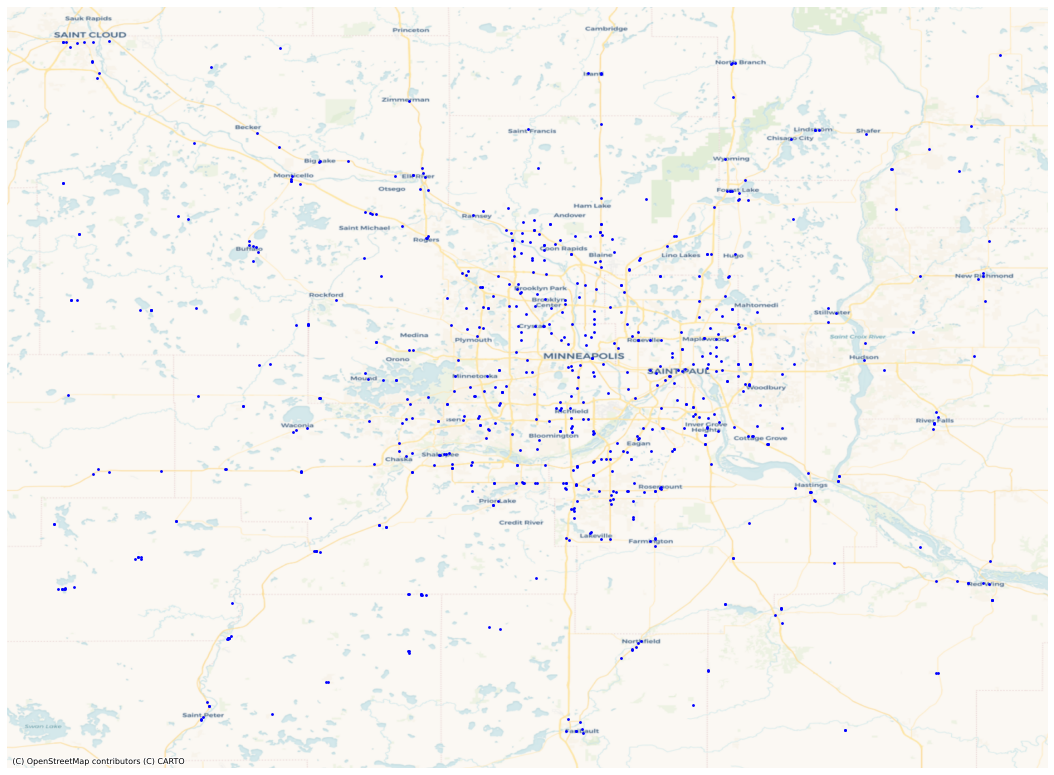

In [7]:
# Convert back to GDF
gdf_results = gpd.GeoDataFrame(results_cleaned, geometry=results_cleaned.geometry)

# Plot Results
f, ax = plt.subplots(1, figsize=(28, 14))

ax.scatter(gdf_results["Longitude"], gdf_results["Latitude"], c = "blue", s = 8, linewidth = 0)

contextily.add_basemap(ax, source = contextily.providers.CartoDB.Voyager, crs = "EPSG:4326")

ax.set_axis_off()

plt.show()

In [8]:
# Write GDF to SHP
gdf_results.set_crs("EPSG:4326")

gdf_results.to_file("potential_locations.shp")